# Network-based Gene Prioritization from GWAS Data
MED283: Network Biology & Biomedicine  
Nadia Arang & Kevin Chau

TODO:
1. Map rescores to old gene summaries table
2. SNP assignment according to regression analysis

In [1]:
%matplotlib inline

import ndex2
import math
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

## Initial data loading

GIANT
> Greene CS*, Krishnan A*, Wong AK*, Ricciotti E, Zelaya RA, Himmelstein DS, Zhang R, Hartmann BM, Zaslavsky E, Sealfon SC, Chasman DI, FitzGerald GA, Dolinski K, Grosser T, Troyanskaya OG. (2015). Understanding multicellular function and disease with human tissue-specific networks. Nature Genetics. 10.1038/ng.3259w.

PCNet
> Huang JK*, Carlin DE*, Yu MK, Zhang W, Kreisberg JF, Tamayo P, Ideker T. (2018). Systematic Evaluation of Molecular Networks for Discovery of Disease Genes. Cell Systems. 4 (6): 484-495.e5. doi: 10.1016/j.cels.2018.03.001

In [2]:
# Load network from server
# PCNet
# pc_nice = ndex2.create_nice_cx_from_server(server = "http://public.ndexbio.org", 
#                                            uuid = "f93f402c-86d4-11e7-a10d-0ac135e8bacf")

# GIANT; Brain-specific, 0.2-confidence filter
bn_nice = ndex2.create_nice_cx_from_server(server = "http://public.ndexbio.org", 
                                           uuid = "19677bff-6037-11e8-a4bf-0ac135e8bacf")

In [3]:
# Cast as networkx object
# First cast to pandas since networkx 2.1 is incompatible with ndex2
# nt_pd = pc_nice.to_pandas_dataframe()
nt_pd = bn_nice.to_pandas_dataframe()
net = nx.from_pandas_edgelist(nt_pd)

In [4]:
# Load gene summary table
gene_summaries_given = pd.read_csv("../src/gene_level_summary_stats_pmid_25056061.txt", 
                                   header = 0, sep = '\t', index_col = 1)
gene_summaries_given.head()

,Unnamed: 0,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance
Gene,,,,,,,,,
HIST1H4K,5905,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0
HIST1H2AK,5867,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0
HIST1H2BN,5883,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0
HIST1H2AL,5868,6,27941085,27941555,10,rs13199772,27942064.0,7.053790e-10,979.0
HIST1H1B,5855,6,27942548,27943338,10,rs13199772,27942064.0,7.053790e-10,484.0


Text(0.5,0,'Chromosome')

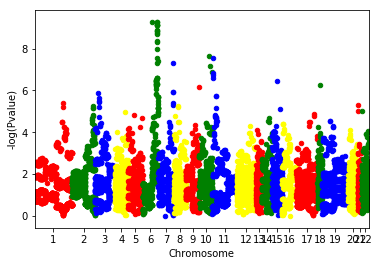

In [5]:
# Quick Manhattan plot
gs_man = gene_summaries_given
gs_man["-log(Pvalue)"] = -np.log10(gene_summaries_given["TopSNP P-Value"])
gs_man["Chr"] = gene_summaries_given["Chr"].astype("category")
gs_man = gene_summaries_given.sort_values("Chr")

gs_man["ind"] = range(len(gs_man))
gs_groups = gs_man.groupby(("Chr"))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = ["red", "green", "blue", "yellow"]

x_labels = []
x_labels_pos = []

for num, (name, group) in enumerate(gs_groups):
    group.plot(kind = "scatter", x = "ind", y = "-log(Pvalue)", color = colors[num % len(colors)], ax = ax)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(gs_man)])
# ax.set_ylim([0, 3.5])
ax.set_xlabel('Chromosome')

In [6]:
# Load snp summary table
snp_summaries = pd.read_csv("../src/snp_level_summary_stats_pmid_25056061.txt", 
                            header = 0, sep = '\t', index_col = 0, na_values = ".")
snp_summaries.head()

,hg18chr,bp,a1,a2,or,se,pval,info,ngt,CEUaf
snpid,,,,,,,,,,
rs3131972,1,742584,A,G,1.0257,0.0835,0.761033,0.1613,0,0.160550
rs3131969,1,744045,A,G,1.0221,0.0801,0.784919,0.2225,0,0.133028
rs3131967,1,744197,T,C,1.0227,0.0858,0.793520,0.2060,0,NaN
rs1048488,1,750775,T,C,0.9749,0.0835,0.761041,0.1613,0,0.836449
rs12562034,1,758311,A,G,1.0011,0.0756,0.987899,0.1856,3,0.092593


### Gene significance by normalized p-value

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3128073/

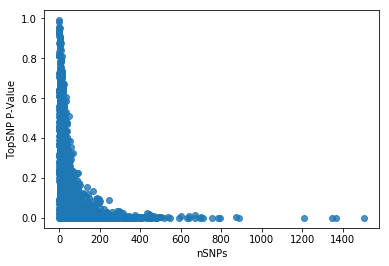

In [7]:
# Rationale
fig2 = plt.figure()
ax = fig2.add_subplot(111)
sns.regplot((gene_summaries_given["nSNPs"]), (gene_summaries_given["TopSNP P-Value"]), fit_reg = False)
#ax.set_ylim(-0.3, 1)

In [8]:
fig2.savefig("../data/gene_snp_correlation.png")

In [9]:
from scipy.stats import pearsonr
pearsonr(gene_summaries_given["nSNPs"], gene_summaries_given["TopSNP P-Value"])

(-0.20155646638624297, 5.578098517955562e-137)

There is clear correlation between number of captured SNPs and the assigned TopSNP p-value, so we should probably normalize gene score by number of captured SNPs

In [10]:
# Assign SNPs to genes based on +/- nkb window
nkb = 10

# Init new gene_summaries dataframe
gene_summaries = gene_summaries_given.loc[:, ["Chr", "Gene Start", "Gene End"]]
gene_summaries.head()

,Chr,Gene Start,Gene End
Gene,,,
HIST1H4K,6,27906930,27907284
HIST1H2AK,6,27913636,27914096
HIST1H2BN,6,27914418,27914867
HIST1H2AL,6,27941085,27941555
HIST1H1B,6,27942548,27943338


Rescoring genes normalized by number of SNPs actually assigned to the gene.

In [11]:
gene_scores = []
snp_counts = []
min_p = []
for gidx, gene in gene_summaries.iterrows():
    chrom = gene["Chr"]
    
    # filter for chromosome
    this_snps = snp_summaries[snp_summaries["hg18chr"] == chrom]
    
    # filter for upstream endpoint
    this_snps = this_snps[this_snps["bp"] >= gene["Gene Start"] - (nkb * 1000)]
    
    # filter for downstream endpoint
    this_snps = this_snps[this_snps["bp"] <= gene["Gene End"] + (nkb * 1000)]
    
    # Calculate adjusted bonferroni-adjusted p-value -> "gene score"
    # pvals = [p * snp_summaries.shape[0] for p in this_snps.loc[:, "pval"].tolist()]
    pvals = [p for p in this_snps.loc[:, "pval"].tolist()]
    adj_score = min(pvals) / len(pvals)
    min_p.append(min(pvals))
    gene_scores.append(adj_score)
    snp_counts.append(len(pvals))
gene_summaries["Gene Score"] = -np.log(gene_scores)
gene_summaries["nSNPs"] = snp_counts
gene_summaries["TopSNP P-Value"] = min_p

In [12]:
gene_summaries_preoverlap = gene_summaries
gene_summaries_preoverlap.head()

,Chr,Gene Start,Gene End,Gene Score,nSNPs,TopSNP P-Value
Gene,,,,,,
HIST1H4K,6,27906930,27907284,23.481719,8,5.071180e-10
HIST1H2AK,6,27913636,27914096,24.174866,16,5.071180e-10
HIST1H2BN,6,27914418,27914867,24.235491,17,5.071180e-10
HIST1H2AL,6,27941085,27941555,23.374871,10,7.053790e-10
HIST1H1B,6,27942548,27943338,23.374871,10,7.053790e-10


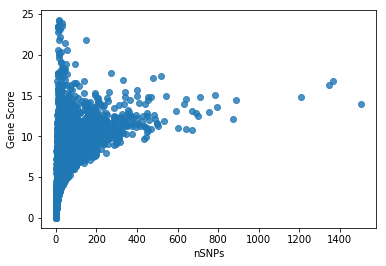

In [13]:
# Plot the gene rescore vs nSNPs
fig_rescore = plt.figure()
ax = fig_rescore.add_subplot(111)
sns.regplot(gene_summaries["nSNPs"], gene_summaries["Gene Score"], fit_reg = False)

In [14]:
fig_rescore.savefig("../data/gene_score_correlation.png")

In [15]:
pearsonr(gene_summaries["nSNPs"], gene_summaries["Gene Score"])

(0.46740209322671267, 0.0)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


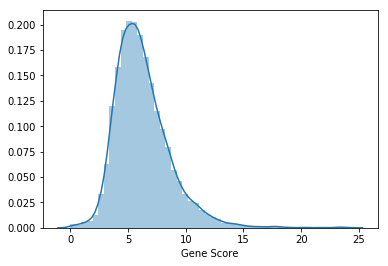

In [16]:
fig_dist = plt.figure()
ax = fig_dist.add_subplot(111)
sns.distplot(gene_summaries["Gene Score"])

In [17]:
fig_dist.savefig("../data/GeneScoreDistribution.png")

In [18]:
new_threshold = -math.log(0.05 / 20000)
new_threshold

12.89921982609012

Initial size of significant gene set

In [19]:
gene_summaries[gene_summaries["Gene Score"] >= new_threshold].shape

(231, 6)

### Adding information to the network

In [20]:
nx.set_node_attributes(net, values = gene_summaries.T.to_dict())

## PageRank

Create normalized adjacency matrix

In [29]:
pagerank = nx.pagerank(net)
gene_summaries["Gene ReScorePR"] = [-np.log(pagerank[_]) + gene_summaries.loc[_, "Gene Score"] 
                                    if _ in pagerank else gene_summaries.loc[_, "Gene Score"]
                                    for _ in gene_summaries.index]

In [30]:
gene_summaries.sort_values(by = ["Gene ReScorePR"], axis = 0, ascending = False).head()

,Chr,Gene Start,Gene End,Gene Score,nSNPs,TopSNP P-Value,Gene ReScorePR
Gene,,,,,,,
HIST1H2BN,6,27914418,27914867,24.235491,17,5.071180e-10,35.677608
PGBD1,6,28357342,28378305,23.912550,30,1.236040e-09,34.485277
HIST1H2BD,6,26266327,26279555,23.054182,15,1.458100e-09,33.905292
HIST1H1E,6,26264537,26265322,22.744027,11,1.458100e-09,33.383207
HIST1H1B,6,27942548,27943338,23.374871,10,7.053790e-10,32.106955


In [31]:
gene_summaries.sort_values(by = ["Gene ReScorePR"], axis = 0, ascending = False).to_csv("../data/gene_list_output_take2.csv")

In [72]:
gene_summaries[gene_summaries["Gene ReScorePR"] >= new_threshold].shape

(9333, 8)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


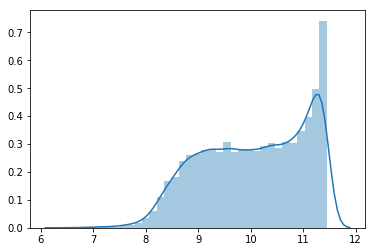

In [34]:
sns.distplot(-np.log(list(pagerank.values())))

## Random Walk With Restart

In [35]:
A = nx.to_numpy_matrix(net)
D = np.diag(list(dict(net.degree()).values()))
invD = np.diag([1 / _ if _ > 0 else 0 for _ in list(dict(net.degree()).values())])

In [36]:
alpha = 0.1

In [37]:
similarity = alpha * np.linalg.inv((np.eye(len(A)) - (1 - alpha) * np.dot(A, invD)))

In [43]:
# Subset the similarity matrix
# Get indexes of nodes found in gene_summaries
idx = [list(net.nodes).index(_) for _ in gene_summaries.index if _ in list(net.nodes)]
sub_sim = np.take(np.take(similarity, idx, 0), idx, 1)

In [52]:
# Also subset the summaries matrix
sub_sum = gene_summaries.loc[:, "Gene Score"][idx]

In [62]:
# Rescoring calculation
rescore = np.dot(sub_sim, sub_sum)

In [65]:
rescore_array = np.array(rescore[0, :])[0, :]
rescore_dict = {g: s for g, s in zip(sub_sum.index, rescore_array)}

In [66]:
gene_summaries["Gene ReScoreRWR"] = [rescore_dict[gene] 
                                     if gene in rescore_dict 
                                     else gene_summaries.loc[gene, "Gene Score"] 
                                     for gene in gene_summaries.index]

In [73]:
gene_summaries[gene_summaries["Gene ReScoreRWR"] >= new_threshold].shape

(895, 8)

## Validation

In [69]:
gene_summaries.sort_values(by = "Gene ReScoreRWR", axis = 0, ascending = False).head()

,Chr,Gene Start,Gene End,Gene Score,nSNPs,TopSNP P-Value,Gene ReScorePR,Gene ReScoreRWR
Gene,,,,,,,,
MCC,5,112434689,112658511,12.619102,183,0.000605,23.894569,76.663970
VPS45,1,148315890,148384129,10.427698,16,0.000474,21.066816,70.134934
CARS2,13,110091759,110156464,11.540753,50,0.000486,22.462777,61.680091
NPAT,11,107547084,107565274,3.493207,9,0.273629,12.668710,61.034015
LRP5,11,67836683,67973319,13.904576,63,0.000058,23.796631,58.744471


In [71]:
gene_summaries.sort_values(by = "Gene ReScorePR", axis = 0, ascending = False).head()

,Chr,Gene Start,Gene End,Gene Score,nSNPs,TopSNP P-Value,Gene ReScorePR,Gene ReScoreRWR
Gene,,,,,,,,
HIST1H2BN,6,27914418,27914867,24.235491,17,5.071180e-10,35.677608,24.235491
PGBD1,6,28357342,28378305,23.912550,30,1.236040e-09,34.485277,22.020815
HIST1H2BD,6,26266327,26279555,23.054182,15,1.458100e-09,33.905292,23.054182
HIST1H1E,6,26264537,26265322,22.744027,11,1.458100e-09,33.383207,2.317093
HIST1H1B,6,27942548,27943338,23.374871,10,7.053790e-10,32.106955,23.374871


In [81]:
gs_rwr = gene_summaries.sort_values(by = ["Gene ReScoreRWR"], axis = 0, ascending = False).index.tolist()[:1000]

In [82]:
gs_pr = gene_summaries.sort_values(by = ["Gene ReScorePR"], axis = 0, ascending = False).index.tolist()[:1000]

In [83]:
spearmanr(gs_rwr, gs_pr)

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


SpearmanrResult(correlation=0.03477287877287877, pvalue=0.27195484106516743)